# Creating the Bathymetry

In this notebook, we will explore how to create the grid of a model for Guft of Mexico (GoM).
First, import packages to re-create and visualize the model grid here:

In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import netCDF4 as nc4

### Bathymetry Source File
To generate the bathymetry for the model, first obtain a subset of the global GEBCO bathymetry grid from here: https://download.gebco.net/

For GoM's model, I requested a subset covering my grid ranging from 15°N 75.0°W and 35°N 100.0°W, and I stored the bathymetry as `GEBCO_Bathymetrygebco_2024_n35.0_s15.0_w-100.0_e-75.nc`.

### Interpolating Bathymetry onto the Model Domain
Next, I use an interpolation function to interpolate the GEBCO Bathymetry onto the domain of my model.

In [87]:
# read in the bathymetry grid
file_path = '/Users/spartan/Downloads/cs185c_spring2025/not_push/GEBCO_08_Apr_2025_9da5a5ce2313/gebco_2024_n35.0_s15.0_w-100.0_e-75.0.nc'
ds = nc4.Dataset(file_path)
gebco_lon = ds.variables['lon'][:]
gebco_lat = ds.variables['lat'][:]
Gebco_bathy = ds.variables['elevation'][:]
ds.close()

# create a meshgrid of the lon and lat
Gebco_Lon, Gebco_Lat = np.meshgrid(gebco_lon, gebco_lat)
print(Gebco_Lon)

[[-99.99791667 -99.99375    -99.98958333 ... -75.01041667 -75.00625
  -75.00208333]
 [-99.99791667 -99.99375    -99.98958333 ... -75.01041667 -75.00625
  -75.00208333]
 [-99.99791667 -99.99375    -99.98958333 ... -75.01041667 -75.00625
  -75.00208333]
 ...
 [-99.99791667 -99.99375    -99.98958333 ... -75.01041667 -75.00625
  -75.00208333]
 [-99.99791667 -99.99375    -99.98958333 ... -75.01041667 -75.00625
  -75.00208333]
 [-99.99791667 -99.99375    -99.98958333 ... -75.01041667 -75.00625
  -75.00208333]]


In [102]:
# recreate the model grid - see previous notebook on creating the model grid for details
# 15°S 75.0°W and 35°N 100.0°W
delX = 1/16
delY = 1/16
xgOrigin = -100
ygOrigin = 16
n_rows = (35 - 15) * 16
n_cols = (100 - 75) * 16
print(n_rows, n_cols)

xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
XC, YC = np.meshgrid(xc, yc)
print('Double check shape:', np.shape(xc),np.shape(yc))

320 400
Double check shape: (400,) (320,)


In [103]:
# interpolate the gebco data onto the model grid
Model_bathy = griddata(np.column_stack([Gebco_Lon.ravel(),Gebco_Lat.ravel()]), Gebco_bathy.ravel(), (XC, YC), method='nearest')

In [104]:
# set points on land to 0
Model_bathy[Model_bathy>0] = 0

### Visualizing the Bathymetry Grid
Finally, I create a plot of the bathymetry and compare with the source data to ensure everything turns out as expected:

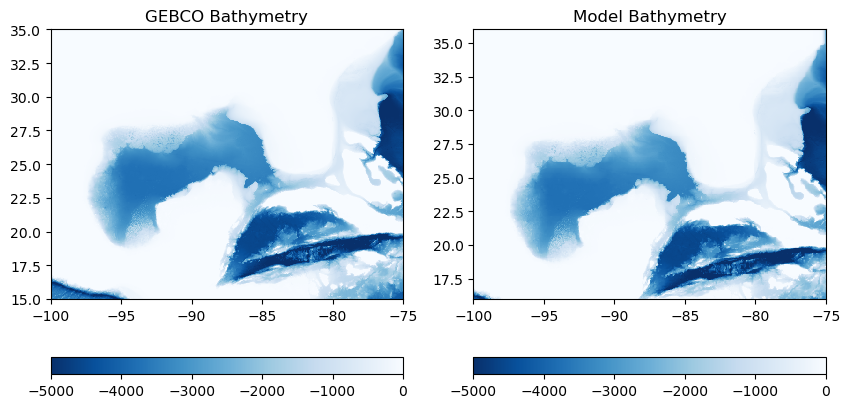

In [105]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(Gebco_Lon, Gebco_Lat, Gebco_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('GEBCO Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, Model_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.show()

### Checking for isolated regions
One potential problem that can be encountered in ocean models occurs with isolated regions

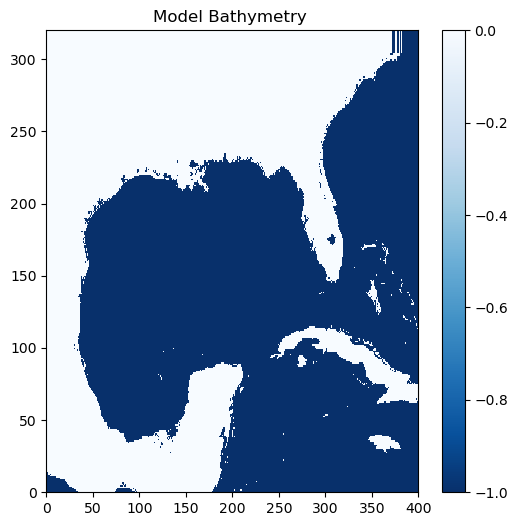

In [106]:
plt.figure(figsize=(6,6))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry ')

plt.show()

As we can see, there are several isolated regions includes the San Francisco Bay and the Salton Sea. In addition, there is an area of extreme detail in the area of British Columbia, Canada. Before proceeding with the model, these regions need to be addressed.

Fortunately, Mike has written a tool to fill in these unconnected regions. You can clone his [eccoseas](https://github.com/mhwood/eccoseas) repository to access a tool related to this process. If you clone it in the current directory, you can use import it here:

In [107]:
from eccoseas.downscale import bathymetry as edb

With the tools imported, we can now use the `fill_unconnected_model_regions` to fill in these regions.

In [108]:
Model_bathy = edb.fill_unconnected_model_regions(Model_bathy, central_wet_row=100, central_wet_col=100)

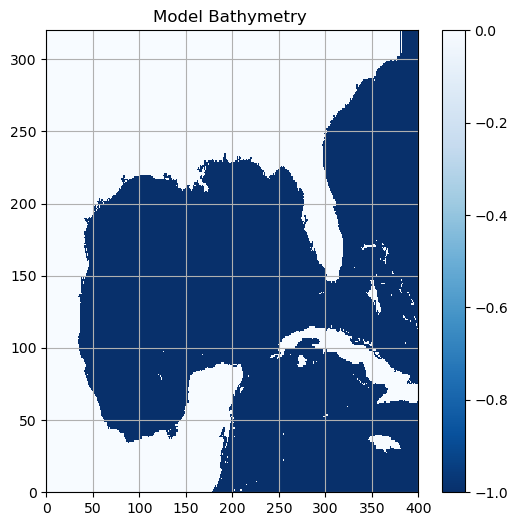

In [109]:
plt.figure(figsize=(6,6))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.grid()
plt.title('Model Bathymetry ')

plt.show()

### Checking for problem areas
Another potential problem that can be encountered in ocean models occurs in regions where there is shallow bathymetry in enclosed bays. In these regions, there can be fast currents and strong dynamics. If this is your area of interest, then this is great! If not, it may cause problems in your domain. One option is to manually fill in these areas to avoid any potential issues. 

In [153]:
# fill in some areas around BC
Model_bathy_filled = np.copy(Model_bathy)
Model_bathy_filled[Model_bathy_filled > -20] = 0
# One way
Model_bathy_filled_manual = Model_bathy_filled
# Model_bathy_filled_manual[138:140, 120:130] = 0

In [157]:
# Other way
from scipy.ndimage import label

def fill_enclosed_water(bathy):
    # Step 1: Water mask: where bathy < 0 (i.e., water)
    water_mask = bathy < 0

    # Step 2: Label all connected water regions
    labeled_array, num_features = label(water_mask)

    # Step 3: Find labels connected to the border
    rows, cols = bathy.shape
    border_labels = set()

    # Check all four borders
    border_labels.update(np.unique(labeled_array[0, :]))
    border_labels.update(np.unique(labeled_array[-1, :]))
    border_labels.update(np.unique(labeled_array[:, 0]))
    border_labels.update(np.unique(labeled_array[:, -1]))

    # Step 4: Replace enclosed water (not connected to border) with land (0.)
    filled = np.copy(bathy)
    for label_id in range(1, num_features + 1):
        if label_id not in border_labels:
            filled[labeled_array == label_id] = 0.
    print(cols)
    return filled
    
Model_bathy_filled_func = fill_enclosed_water(Model_bathy_filled)
print(Model_bathy_filled_func.shape)


400
(320, 400)


Then, plot the filled bathymetry to ensure it looks as expected

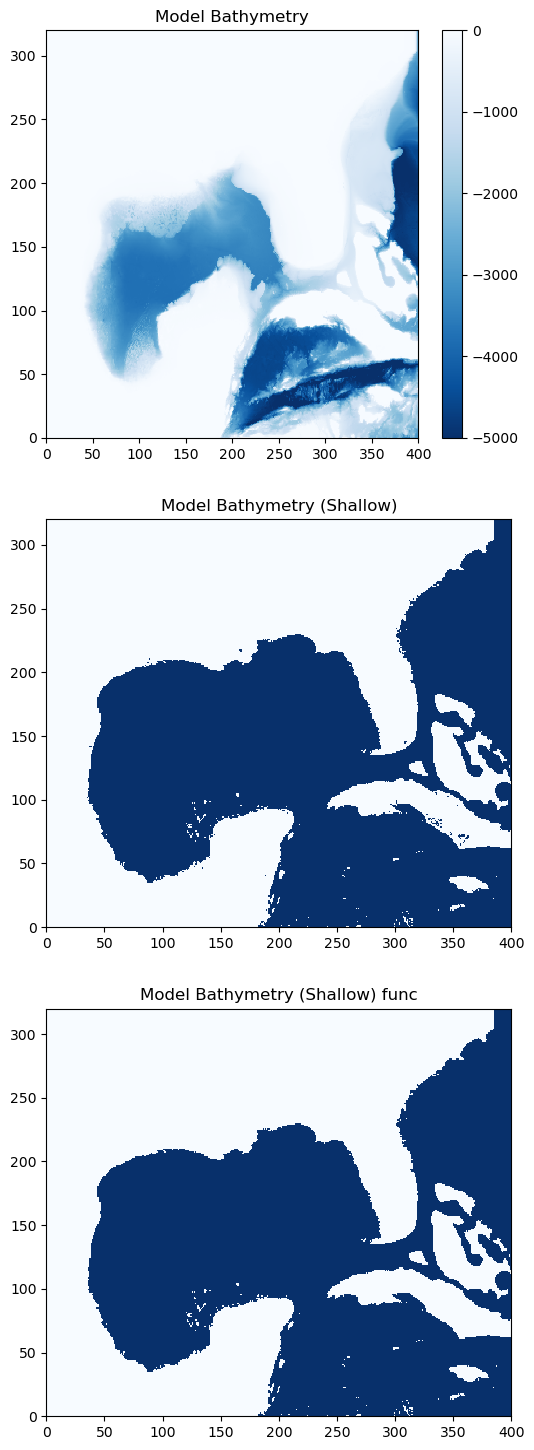

In [155]:
plt.figure(figsize=(6,18))
plt.subplot(3,1,1)
C = plt.pcolormesh(Model_bathy_filled, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry')

plt.subplot(3,1,2)
C = plt.pcolormesh(Model_bathy_filled_manual, vmin=-1, vmax=0, cmap='Blues_r')
plt.title('Model Bathymetry (Shallow)')

plt.subplot(3,1,3)
C = plt.pcolormesh(Model_bathy_filled_func, vmin=-1, vmax=0, cmap='Blues_r')
plt.title('Model Bathymetry (Shallow) func')

plt.show()

In [133]:
output_file = '../input/bathymetry.bin'
Model_bathy_filled_func.ravel('C').astype('>f4').tofile(output_file)

This will be implemented into the model by editing the `PARM05` dataset of the `data` file as follows:
```
 &PARM05
 bathyFile = 'bathymetry.bin,
 &
```